## Monte Carlo exercise I: 
find some data (n=20 observations) here. 
https://www.uio.no/studier/emner/matnat/math/STK4021/h18/beskjeder/small_data.txt

Assume the data come from a normal distribution with unknown mean $\theta$ and known variance $(\sigma^2=1)$. Use a normal prior for $\theta, N(\mu_0, \tau_0^2)$, with $\mu_0=1$ and $\tau_0=1$. 

Then we have an explicit posterior, with explicit expressions for all quantities of interest (here: the posterior mean, the posterior standard deviation and the 90% posterior interval for $\theta$), but we will pretend that we do not know the full posterior, but can only evaluate the unnormalised posterior (prior times likelihood). Compute all three quantities of interest (and the a histogram of posterior draws when possible) using   

a) Importance sampling;   
b) Rejection sampling and   
c) MCMC (use for example a variant of the simple Metropolis scheme we saw in the lecture).   

Compare the estimated quantities of interest with the true values (and the histogram of draws with the true posterior density).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
y = np.array([2.056865, 2.067801, 3.462714, 2.272823, 2.478708,
1.942217, 1.582034, 2.706005, 2.477326, 2.159151,
2.460221, 1.459483, 1.389145, 2.187833, 1.819716,
1.733246, 1.587644, 2.54228, 1.876315, 1.351894])

n = len(y)
plt.hist(y)

(array([3., 3., 3., 4., 1., 4., 1., 0., 0., 1.]),
 array([1.351894, 1.562976, 1.774058, 1.98514 , 2.196222, 2.407304,
        2.618386, 2.829468, 3.04055 , 3.251632, 3.462714]),
 <a list of 10 Patch objects>)

In [2]:
np.mean(y)

2.08067105

## Exact solution

!["title"](assets/ex28sept-posterior_calc.png)

In [3]:
post_prec = 1 + n
post_std = 1/np.sqrt(post_prec)
post_mu = ( 1 + 20*np.mean(y) ) / (post_prec)
print(post_mu)
print(post_std)
print(post_mu + post_std*np.array(scipy.stats.norm.interval(0.9)))

2.0292105238095237
0.2182178902359924
[1.67027404 2.38814701]


## 0) Numerical Integration (up to normalizing constant)

In [4]:
def mc_integrate(f, low = 0, high = 1, samples = 100000):
    u = np.random.uniform(low = low, high = high, size=samples)
    pmf = f(u)*(high-low)
    return np.mean(pmf)

In [5]:
def post_nonnorm(theta):
    return np.exp(-0.5 *( (theta-1)**2 + np.sum((y-theta)**2)  ))
post_nonnorm = np.vectorize(post_nonnorm)

In [6]:
const = mc_integrate(post_nonnorm, 0,4, samples = int(1e6))

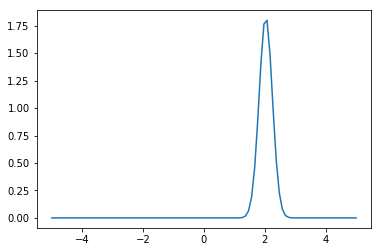

In [7]:
post_norm = lambda theta: 1/const * post_nonnorm(theta)
x = np.linspace(-5,5,100)
pdf = [post_norm(i) for i in x]
plt.plot(x,pdf)

In [8]:
mc_integrate(lambda x: post_norm(x), 0,4)

1.0000339535385525

In [9]:
# Expected value
mu = mc_integrate(lambda x: x*post_norm(x), 0,4)
mu

2.034693338291385

In [10]:
# Variance
var = mc_integrate(lambda x: (x-mu)**2 *post_norm(x), 0,4)
np.sqrt(var)

0.21949735281383007

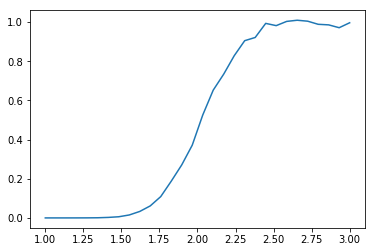

In [11]:
## Confidence interval
X = np.linspace(1,3,30)
Q = np.array([mc_integrate(post_norm, 0,x, samples = 5000) for x in X])
plt.plot(X,Q)

In [15]:
print(X[np.argmax(Q > 0.05)], X[np.argmax(Q > 0.95)])

1.6896551724137931 2.4482758620689653


## a) Importance sampling
We know the 

(array([1.5000e+01, 3.3500e+02, 3.0170e+03, 1.3349e+04, 2.8776e+04,
        3.1593e+04, 1.7396e+04, 4.8300e+03, 6.6000e+02, 2.9000e+01]),
 array([-8.79388807, -7.07851552, -5.36314297, -3.64777042, -1.93239787,
        -0.21702532,  1.49834723,  3.21371978,  4.92909233,  6.64446488,
         8.35983743]),
 <a list of 10 Patch objects>)

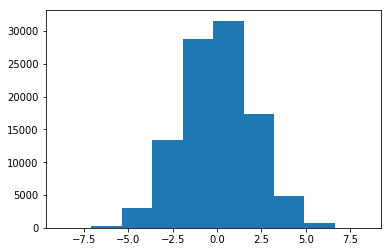

In [16]:
# We still know the nonnormalized posterior:
import scipy.stats
def post_nonnorm(theta):
    return np.exp(-0.5 *( (theta-1)**2 + np.sum((y-theta)**2)  ))
post_nonnorm = np.vectorize(post_nonnorm)

# Lets choose a N(0,2) as our approximate distribution
ttp = scipy.random.normal(0,2, size = 100000)
plt.hist(ttp)

In [17]:
def importance_sample(f, post_nonnorm, size = 100000):
    # Importance sample estimates, using a normal(0,2) as approximate
    ttp = scipy.random.normal(2,2, size = size)
    weights = post_nonnorm(ttp)/scipy.stats.norm.pdf(ttp, 0,2)
    w_tilde = weights/np.sum(weights)
    return sum(f(ttp)*w_tilde)

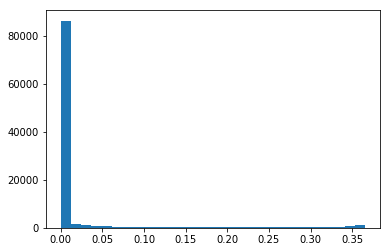

In [18]:
weights = post_nonnorm(ttp)/scipy.stats.norm.pdf(ttp, 0,2)
w_tilde = weights/np.sum(weights)
a = plt.hist(weights, bins = 30)

In [19]:
# Expectation
mean = importance_sample(lambda x: x, post_nonnorm)
mean

2.0525499068693334

In [20]:
## Variance:
np.sqrt(importance_sample(lambda x: (x-mean)**2, post_nonnorm))

0.21798968795849646

In [21]:
X = np.linspace(1,3,50)

In [22]:
Q = np.array([importance_sample(lambda y: y < x, post_nonnorm) for x in X])

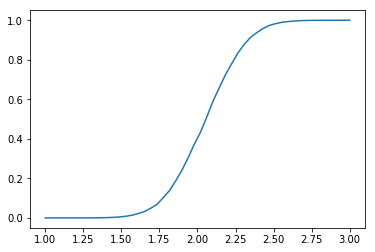

In [23]:
plt.plot(X,Q)

In [27]:
print(X[np.argmax(Q > 0.05)], X[np.argmax(Q > 0.95)])

1.7346938775510203 2.4285714285714284



### b) Rejection sampling

In [28]:
# we still got the non-normalized posterior:
import scipy.stats
def post_nonnorm(theta):
    return np.exp(-0.5 *( (theta-1)**2 + np.sum((y-theta)**2)  ))
post_nonnorm = np.vectorize(post_nonnorm)


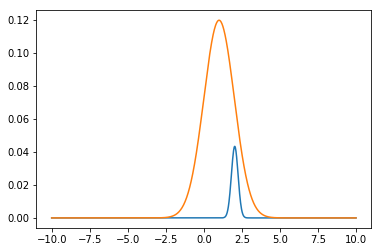

In [29]:
# need a sample density g so that post_nonnorm < M*g for all theta
thetas = np.linspace(-10,10,1000)


p0 = post_nonnorm(thetas)
g = lambda theta : scipy.stats.distributions.norm.pdf(theta, 1,1)*0.3
#g = scipy.stats.distributions.norm.pdf(thetas, 1,1)*0.5
plt.plot(thetas, p0)
plt.plot(thetas, g(thetas))

In [30]:
size = int(10e5)
theta_candidate = np.random.normal(loc = 1, scale=1, size=size)
prob_accept = post_nonnorm(theta_candidate) / g(theta_candidate)
keep = prob_accept > np.random.uniform(size = size)
theta = theta_candidate[keep]

In [31]:
mean = theta.mean()
mean

2.0296642290342306

In [32]:
std = np.sqrt(np.mean((theta- mean)**2))
std

0.21707260599425152

1.693877551020408 2.387755102040816


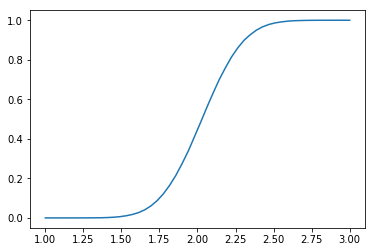

In [34]:
X = np.linspace(1,3,50)
Q = np.array([np.mean(theta < x) for x in X])
plt.plot(X,Q)
print(X[np.argmax(Q > 0.05)], X[np.argmax(Q > 0.95)])

### c) MCMC (use for example a variant of the simple Metropolis scheme we saw in the lecture).   


In [35]:
# we STILL know the non-normalized posterior:
import scipy.stats
def post_nonnorm(theta):
    return np.exp(-0.5 *( (theta-1)**2 + np.sum((y-theta)**2)  ))
post_nonnorm = np.vectorize(post_nonnorm)


In [36]:
size = int(1e5)
theta = np.zeros(size)#+1.5

for i in range(1,size):
    theta_candidate = theta[i-1] + (np.random.uniform()-0.5)*0.1
    prob_accept = min(1, post_nonnorm(theta_candidate)/post_nonnorm(theta[i-1]))
    
    accept = np.random.uniform() < prob_accept

    theta[i] = theta_candidate if accept else theta[i-1]

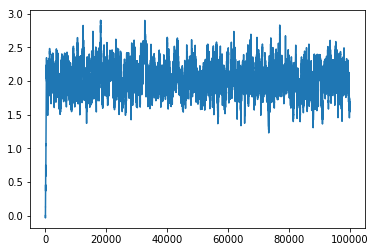

In [37]:
plt.plot(theta)

In [38]:
psample = theta[int(size/2):]

In [39]:
mean = np.mean(psample)
mean

2.013379904407437

In [40]:
std = np.sqrt(np.mean ( (psample-mean)**2))
std

0.20976009991502514

1.693877551020408 2.387755102040816


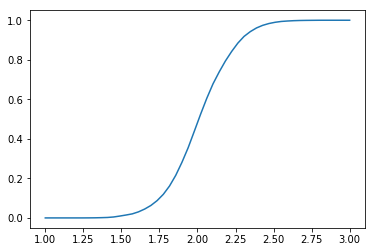

In [41]:
X = np.linspace(1,3,50)
Q = np.array([np.mean(psample < x) for x in X])
plt.plot(X,Q)
print(X[np.argmax(Q > 0.05)], X[np.argmax(Q > 0.95)])


## Monte Carlo exercise II: 
use the same data as above, but assume a different model for the data, a t-distribution with 3 degrees of freedom instead: 

$y_i = \theta + \sigma/\sqrt{3}* \epsilon_i$, where $\epsilon_i \sim t_3$. 

The variance is still assumed known ($\sigma=1$). 
Use the same prior as before, and compute the same quantities as in the previous exercise with the three different Monte Carlo methods 
(but here we cannot easily compare against the true values like in the previous exercise).


#### solution
since $y_i$ is a function of t:

$$ weights = exp(
    log(dnorm(ttp,1,1) 
    + log( t.pdf( (ttp-y_hat)*sqrt(n)/sigma, freedoms=3)*sqrt(n)/sigma)
    - log(dnorm(ttp, 0, 3))
    )
$$

In [43]:
# This is the same, but with t pdf:
scipy.stats.distributions.t.pdf()

y_i

Signature: scipy.stats.distributions.t.pdf(x, *args, **kwds)
Docstring:
Probability density function at x of the given RV.

Parameters
----------
x : array_like
    quantiles
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
pdf : ndarray
    Probability density function evaluated at x
File:      /usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


## MCMC exercise: 
attempt to set up an MCMC to simulate from the target density of type p(theta) = 0.25*exp(-abs(theta-a0)) + 0.25*exp(-abs(theta+a0)) with a0 = 2.00. Do this by proposals theta[i+1] being a uniform on [theta[i] - b0, theta[i] + b0], where you try out a decent b0.

In [350]:
def distr(theta, a0 = 2.0):
    return 0.25*np.exp(-np.abs(theta-a0)) + 0.25*np.exp(-np.abs(theta+a0))

In [368]:
def MCMC(distr, step_size = 0.1, size = int(1e5), theta0= 0):
    theta = np.zeros(size)+theta0

    for i in range(1,size):
        theta_candidate = theta[i-1] + (np.random.uniform()-0.5)*step_size
        prob_accept = min(1, distr(theta_candidate)/distr(theta[i-1]))

        accept = np.random.uniform() < prob_accept

        theta[i] = theta_candidate if accept else theta[i-1]
        
    return theta

(array([  304.,  1001.,   890.,  1757.,  5063.,  7846.,  9521.,  6911.,
         3160.,  1806.,  3610., 10194., 12184., 10113.,  8405.,  6124.,
         4592.,  4144.,  1663.,   712.]),
 array([-6.28081016, -5.64815   , -5.01548985, -4.38282969, -3.75016953,
        -3.11750937, -2.48484921, -1.85218905, -1.21952889, -0.58686873,
         0.04579143,  0.67845159,  1.31111175,  1.94377191,  2.57643207,
         3.20909223,  3.84175238,  4.47441254,  5.1070727 ,  5.73973286,
         6.37239302]),
 <a list of 20 Patch objects>)

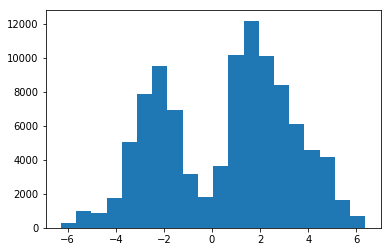

In [367]:
plt.hist(MCMC(distr), bins = 20)

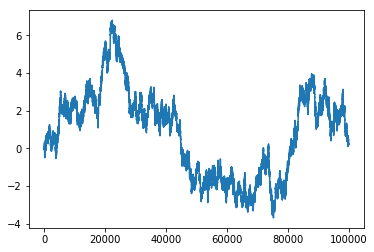

In [362]:
plt.plot(MCMC(distr))

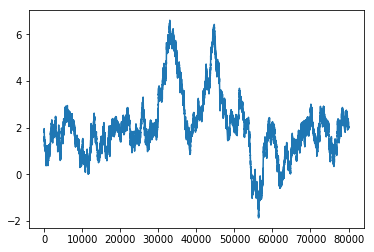

In [361]:
plt.plot((theta[20000:]))

(array([  123.,   226.,  1225.,  1771.,  1713.,  3393.,  7469., 10678.,
        14864., 16408.,  7647.,  2768.,  2639.,  1831.,  1801.,  1349.,
          985.,  1502.,  1238.,   370.]),
 array([-1.86365965, -1.440228  , -1.01679635, -0.5933647 , -0.16993305,
         0.2534986 ,  0.67693024,  1.10036189,  1.52379354,  1.94722519,
         2.37065684,  2.79408849,  3.21752014,  3.64095179,  4.06438344,
         4.48781508,  4.91124673,  5.33467838,  5.75811003,  6.18154168,
         6.60497333]),
 <a list of 20 Patch objects>)

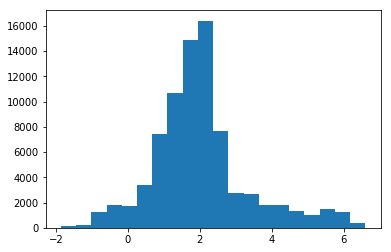

In [356]:
plt.hist(theta[20000:], bins = 20)